In [1]:
import sys
sys.path.append('code/')
from gwBackground import *
from geometry import *
from makeDelayedRateData import *
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
from scipy.special import gammainc
from tqdm.notebook import tqdm
import h5py
from matplotlib import cm

blue = "#1f78b4"
green = "#33a02c"
red = "#e31a1c"

# 0. Preliminaries

As a preliminary, precompute some data that gives us star formation rates and evolutionary time delays at a variety of redshifts.
Specifically, the cell below defines the following arrays:

   * `zs_merger` : An array (length M) of possible redshifts at which binaries might merge
   * `time_delays` : An array (length N) of possible source-frame time delays between binary formation and merger. Time delays are in units of Gyr
   * `zs_formation` : A 2D array (length MxN) that gives the *formation* redshift implied by each pair of merger redshifts and evolutionary time delays from `zs_merger` and `time_delays`
   * `formationRates` : An estimate of the global star formation rate (arbitrary overall normalization) at each redshift in `zs_formation`

In [2]:
rateData = generateTimeDelayData()
zs_merger = rateData['zs']
time_delays = rateData['tds']
zs_formation = rateData['formationRedshifts']
formationRates = rateData['formationRates']

Also import data defining the "power-law integrated sensitivity curves" (PI curves) for the O3 and (projected) O4 observing runs:

In [3]:
O3_PI_freqs,O3_PI = np.loadtxt('../input/O3PICurve.dat',unpack=True,usecols=(0,2),skiprows=4)
design_PI_freqs,design_PI = np.loadtxt('../input/Design_HLV_flow_10.txt',unpack=True,usecols=(0,1))

Next, instantiate an `OmegaGW_BBH` object to help us calculate the expected stochastic background for a variety of birefringence cases. Specifically, the arguments below tell us to consider a BBH population with component masses between 2-100 solar masses and situated across the range of redshifts spanned by `zs_merger`. Later on we will tell the object what specific mass and redshift distributions to assume when integrating across this mass and redshift range; the `gridSize` argument pertains to how precisely this integral is done across BBH masses.

**Note**: This might take a few minutes to run...

In [4]:
### Instantiate SGWB calculator
m_absolute_min = 2.
m_absolute_max = 100.
omg = OmegaGW_BBH(m_absolute_min,m_absolute_max,zs_merger,gridSize=(30,29))

Now that we have our stochastic background calculator ready, choose an assumed BBH mass distribution. This is done by choosing values for the following parameters:
   * `m_min`: Minimum BBH mass
   * `m_max`: Maximum BBH mass
   * `alpha`: Power-law index governing the bulk distribution of BBH component masses
   * `mu_peak`: Mean location of an additional Gaussian peak, on top of the bulk power law
   * `sig_peak`: Standard deviation of the Gaussian peak
   * `frac_peak`: Mixture fraction of events belonging to the Gaussian peak
   * `bq`: Power-law index governing the mass ratio distribution of BBHs

In [5]:
# Define hyperparameters describing mass distribution
m_min = 8.
m_max = 100.
alpha = -3.
mu_peak = 35.
sig_peak = 5.
frac_peak = 0.05
bq = 2

# Pass these to our SGWB calculator
omg.setProbs_plPeak(m_min,m_max,alpha,mu_peak,sig_peak,frac_peak,bq)

Finally, define a fixed model for the BBH merger rate as a function of redshift:

In [6]:
# Regardless of the evolutionary model considered, assume a fixed local merger rate (units 1/Gpc**3/yr)
R0 = 20.

# Madau Dickinson overall rate
alpha = 2.7
beta = 5.6
zpeak = 1.9
dRdV_md = np.power(1.+zs_merger,alpha)/(1.+np.power((1.+zs_merger)/(1.+zpeak),beta))
dRdV_md /= dRdV_md[0]

# Case 1. Uniform-in-Comoving-Volume Rate 

Now let's do some actual inference on $\kappa_D$ and $\kappa_z$ using measured cross-correlation spectra.
The following cell loads arrays of frequencies (e.g. `f_H1L1_O1`), cross-correlation spectra defined at these frequencies (e.g. `C_H1L1_O1`), and uncertainties (`sigma_H1L1_O1`).

We additionally use the `Baseline` object to compute and store the overlap reduction functions associated with Stokes-I and Stokes-V stochastic backgrounds for all three detector baselines.

In [7]:
# Load data
f_H1L1_O1,C_H1L1_O1,sigma_H1L1_O1 = np.loadtxt('../input/H1L1_O1.dat',unpack=True,skiprows=1)
f_H1L1_O2,C_H1L1_O2,sigma_H1L1_O2 = np.loadtxt('../input/H1L1_O2.dat',unpack=True,skiprows=1)
f_H1L1_O3,C_H1L1_O3,sigma_H1L1_O3 = np.loadtxt('../input/H1L1_O3.dat',unpack=True,skiprows=1)
f_H1V1_O3,C_H1V1_O3,sigma_H1V1_O3 = np.loadtxt('../input/H1V1_O3.dat',unpack=True,skiprows=1)
f_L1V1_O3,C_L1V1_O3,sigma_L1V1_O3 = np.loadtxt('../input/L1V1_O3.dat',unpack=True,skiprows=1)

# Instantiate baseline objects
H1L1 = Baseline(Detector.H1(),Detector.L1())
H1V1 = Baseline(Detector.H1(),Detector.V1())
L1V1 = Baseline(Detector.L1(),Detector.V1())

# Use baseline objects to compute overlap reduction functions for Stokes-I and Stokes-V signals
H1L1_gammaI,H1L1_gammaV = H1L1.stokes_overlap_reduction_functions(f_H1L1_O3)
H1V1_gammaI,H1V1_gammaV = H1V1.stokes_overlap_reduction_functions(f_H1L1_O3)
L1V1_gammaI,L1V1_gammaV = L1V1.stokes_overlap_reduction_functions(f_H1L1_O3)

Now let's calculate likelihoods! Our likelihood is a Gaussian, such that the log-likelihood of having measured cross-correlation $\hat C(f)$ given a model stochastic signal $\Omega_M(f)$ is

$$
\ln\mathcal{L} = -\frac{\left(\hat C(f) - \Omega_M(f)\right)^2}{2\sigma^2(f)}.
$$

The log-likelihood for an entire *array* of cross-correlation measurements is just the sum of this, over frequencies:

$$
\ln\mathcal{L} = -\sum_f\frac{\left(\hat C(f) - \Omega_M(f)\right)^2}{2\sigma^2(f)}.
$$

Because the LVK are barbarians, the common choice is to normalize $\hat C(f)$ such that it is an estimator of $\Omega_I(f)$, such that $\langle \hat C(f) \rangle = \Omega_I(f)$.
This means that our model must be of the form

$$
\Omega_M(f) = \Omega_I(f) + \left(\frac{\gamma_V(f)}{\gamma_I(f)}\right)\Omega_V(f),
$$

where $\gamma_I(f)$ and $\gamma_V(f)$ are baseline-dependent overlap reduction functions for Stokes I and V backgrounds.

To evaluate an actual stochastic background spectrum, use the `eval` method of our SGWB calculator. The arguments are, in order,
   * A local merger rate at $z=0$ (units $\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$)
   * An array (of arbitrary normalization) that traces evolution in the local merger rate with redshift. Note that this needs to be defined on the same grid of redshifts we used when we instantiated our `OmegaGW_BBH` object
   * An array of frequencies at which we want to evaluate the background
   * A "comoving distance" birefringent kappa (units $\mathrm{Gpc}^{-1}$)
   * A "redshift" biregringent kappa
The result will be two energy-density spectra, one each for Stokes I and V.

In [8]:
# Range of kappa parameters
kappa_dcs_1D = np.linspace(-0.3,0.3,400)

# Instantiate an array to hold log likelihood values, and loop across kappas
log_likelihoods_dc = np.zeros_like(kappa_dcs_1D)
for i,k in tqdm(enumerate(kappa_dcs_1D)):

    # For each kappa, compute an expected model stochastic background
    OmgI,OmgV = omg.eval(R0,dRdV_md,f_H1L1_O3,k,0)
    
    # Construct baseline-dependent models
    model_background_HL = OmgI + (H1L1_gammaV/H1L1_gammaI)*OmgV
    model_background_HV = OmgI + (H1V1_gammaV/H1V1_gammaI)*OmgV
    model_background_LV = OmgI + (L1V1_gammaV/L1V1_gammaI)*OmgV
    
    # Given this prediction, add the log-likelihoods of our observations from each baseline
    log_likelihoods_dc[i] = 0
    log_likelihoods_dc[i] += np.sum(-(C_H1L1_O1-model_background_HL)**2/(2.*sigma_H1L1_O1**2))
    log_likelihoods_dc[i] += np.sum(-(C_H1L1_O2-model_background_HL)**2/(2.*sigma_H1L1_O2**2))
    log_likelihoods_dc[i] += np.sum(-(C_H1L1_O3-model_background_HL)**2/(2.*sigma_H1L1_O3**2))
    log_likelihoods_dc[i] += np.sum(-(C_H1V1_O3-model_background_HV)**2/(2.*sigma_H1V1_O3**2))
    log_likelihoods_dc[i] += np.sum(-(C_L1V1_O3-model_background_LV)**2/(2.*sigma_L1V1_O3**2))
    
# Subtract off the max so numpy doesn't freak out when we exponentiate, then exponentiate
log_likelihoods_dc -= np.max(log_likelihoods_dc)
likelihoods_dc = np.exp(log_likelihoods_dc)

# Normalize to obtain a proper probability distribution
p_kappa_dc_uniform = likelihoods_dc/np.trapz(likelihoods_dc,kappa_dcs_1D)

0it [00:00, ?it/s]

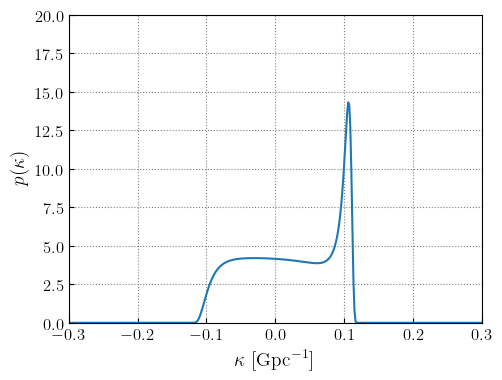

In [9]:
# Plot!
fig,ax = plt.subplots(figsize=(5.33,4))
ax.plot(kappa_dcs_1D,p_kappa_dc_uniform,color=blue)
ax.set_xlabel('$\kappa$ [$\mathrm{Gpc}^{-1}$]')
ax.set_ylabel('$p(\kappa)$')
ax.set_xlim(-0.3,0.3)
ax.set_ylim(0,20)
plt.show()

Do the same thing, but now vary $\kappa_z$ while fixing $\kappa_D = 0$:

In [11]:
# Grid of kappas
kappa_zs_1D = np.linspace(-0.5,0.5,400)

# Loop across kappas
log_likelihoods_z = np.zeros_like(kappa_zs_1D)
for i,k in tqdm(enumerate(kappa_zs_1D)):

    # Evaluate background
    OmgI,OmgV = omg.eval(R0,dRdV_md,f_H1L1_O3,0,k)
    
    model_background_HL = OmgI + (H1L1_gammaV/H1L1_gammaI)*OmgV
    model_background_HV = OmgI + (H1V1_gammaV/H1V1_gammaI)*OmgV
    model_background_LV = OmgI + (L1V1_gammaV/L1V1_gammaI)*OmgV
    
    # Compute likelihood
    log_likelihoods_z[i] = 0
    log_likelihoods_z[i] += np.sum(-(C_H1L1_O1-model_background_HL)**2/(2.*sigma_H1L1_O1**2))
    log_likelihoods_z[i] += np.sum(-(C_H1L1_O2-model_background_HL)**2/(2.*sigma_H1L1_O2**2))
    log_likelihoods_z[i] += np.sum(-(C_H1L1_O3-model_background_HL)**2/(2.*sigma_H1L1_O3**2))
    log_likelihoods_z[i] += np.sum(-(C_H1V1_O3-model_background_HV)**2/(2.*sigma_H1V1_O3**2))
    log_likelihoods_z[i] += np.sum(-(C_L1V1_O3-model_background_LV)**2/(2.*sigma_L1V1_O3**2))
    
# Exponentiate and form a normalized probability distribution
log_likelihoods_z -= np.max(log_likelihoods_z)
likelihoods_z = np.exp(log_likelihoods_z)
p_kappa_z_uniform = likelihoods_z/np.trapz(likelihoods_z,kappa_zs_1D)

0it [00:00, ?it/s]

/Users/tcallister/Documents/Repositories/stochastic-birefringence/code/gwBackground.py:228: RuntimeWarning: overflow encountered in cosh
  cosh_amplification_factor = np.cosh(amplification_factor)
/Users/tcallister/Documents/Repositories/stochastic-birefringence/code/gwBackground.py:229: RuntimeWarning: overflow encountered in sinh
  sinh_amplification_factor = np.sinh(amplification_factor)
/Users/tcallister/Documents/Repositories/stochastic-birefringence/code/gwBackground.py:266: RuntimeWarning: invalid value encountered in multiply
  dedf_I = dedf*cosh_amp
/Users/tcallister/Documents/Repositories/stochastic-birefringence/code/gwBackground.py:267: RuntimeWarning: invalid value encountered in multiply
  dedf_V = dedf*sinh_amp


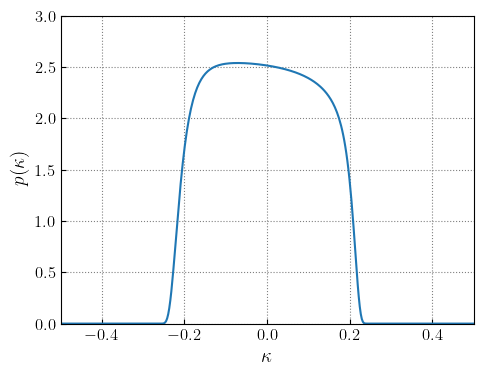

In [12]:
# Plot!
fig,ax = plt.subplots(figsize=(5.33,4))
ax.plot(kappa_zs_1D,p_kappa_z_uniform)
ax.set_xlabel('$\kappa$')
ax.set_ylabel('$p(\kappa)$')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(0,3.)
plt.show()

We can also *jointly* fit $\kappa_D$ and $\kappa_z$, assuming both types of birefringence are allowed to act simultaneously.

In [17]:
# Grid over both kappas
kappa_dcs = np.linspace(-0.5,0.5,201)
kappa_zs = np.linspace(-1.,1.,200)

# Instantiate array to hold log likelihoods
log_likelihoods_joint = np.zeros((kappa_dcs.size,kappa_zs.size))
clipped = np.zeros((kappa_dcs.size,kappa_zs.size))

# Loop over pairs of kappas
for i,kd in tqdm(enumerate(kappa_dcs)):
    for j,kz in enumerate(kappa_zs):
        
        # Don't bother evaluating regions that are way outside the region of likelihood support
        if kz>0.5-2.*kd or kz<-0.5-2.*kd:
            log_likelihoods_joint[i,j] = -np.inf
            clipped[i,j] = 1
            
        else:

            # Compute backgrounds
            OmgI,OmgV = omg.eval(R0,dRdV_md,f_H1L1_O3,kd,kz)

            if np.any(np.isnan(OmgI)):
                log_likelihoods_joint[i,j] = -np.inf
                clipped[i,j] = 1

            else:

                # Form model
                model_background_HL = OmgI + (H1L1_gammaV/H1L1_gammaI)*OmgV
                model_background_HV = OmgI + (H1V1_gammaV/H1V1_gammaI)*OmgV
                model_background_LV = OmgI + (L1V1_gammaV/L1V1_gammaI)*OmgV

                # Tally up log likelihood
                log_likelihoods_joint[i,j] = 0
                log_likelihoods_joint[i,j] += np.sum(-(C_H1L1_O1-model_background_HL)**2/(2.*sigma_H1L1_O1**2))
                log_likelihoods_joint[i,j] += np.sum(-(C_H1L1_O2-model_background_HL)**2/(2.*sigma_H1L1_O2**2))
                log_likelihoods_joint[i,j] += np.sum(-(C_H1L1_O3-model_background_HL)**2/(2.*sigma_H1L1_O3**2))
                log_likelihoods_joint[i,j] += np.sum(-(C_H1V1_O3-model_background_HV)**2/(2.*sigma_H1V1_O3**2))
                log_likelihoods_joint[i,j] += np.sum(-(C_L1V1_O3-model_background_LV)**2/(2.*sigma_L1V1_O3**2))

# Exponentiate and normalize
log_likelihoods_joint -= np.max(log_likelihoods_joint)
likelihoods_joint = np.exp(log_likelihoods_joint)
p_joint_uniform = likelihoods_joint/(np.sum(likelihoods_joint)*(kappa_dcs[1]-kappa_dcs[0])*(kappa_zs[1]-kappa_zs[0]))

0it [00:00, ?it/s]

/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_29670/3147046555.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c = ax.pcolormesh(kappa_dcs,kappa_zs,p_joint_uniform.T,cmap=cmap,vmin=1e-6)


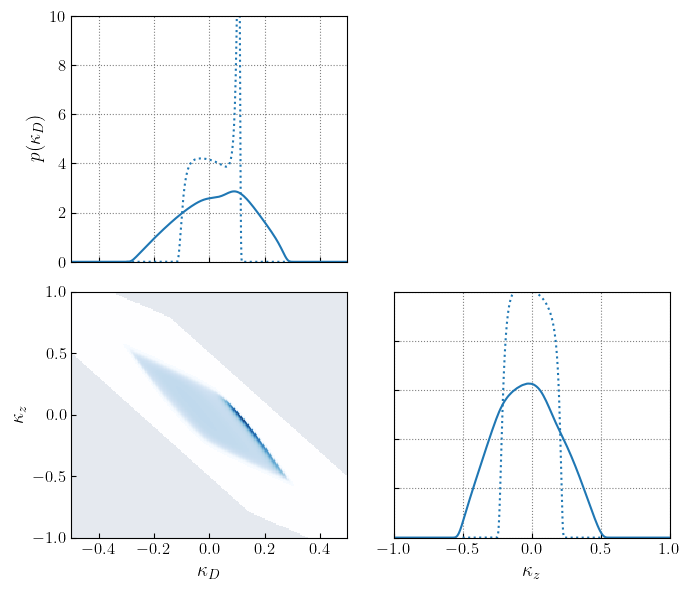

In [19]:
fig = plt.figure(figsize=(7,6))

p_kd = np.trapz(p_joint_uniform,axis=1)
p_kd /= np.trapz(p_kd,kappa_dcs)

p_kz = np.trapz(p_joint_uniform,axis=0)
p_kz /= np.trapz(p_kz,kappa_zs)

ax = fig.add_subplot(223)
cmap = cm.Blues
cmap.set_under("white")
c = ax.pcolormesh(kappa_dcs,kappa_zs,p_joint_uniform.T,cmap=cmap,vmin=1e-6)
c = ax.pcolormesh(kappa_dcs,kappa_zs,clipped.T,cmap='Blues',alpha=0.1)
ax.set_xlabel('$\kappa_D$')
ax.set_ylabel('$\kappa_z$')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-1.,1.)

ax = fig.add_subplot(221)
ax.plot(kappa_dcs,p_kd)
ax.plot(kappa_dcs_1D,p_kappa_dc_uniform,color=blue,ls=':')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_ylabel('$p(\kappa_D)$')

ax = fig.add_subplot(224)
ax.plot(kappa_zs,p_kz)
ax.plot(kappa_zs_1D,p_kappa_z_uniform,color=blue,ls=':')
ax.set_xlim(-1,1)
ax.set_ylim(0,2.5)
ax.set_yticklabels([])
ax.set_xlabel('$\kappa_z$')


#plt.colorbar(c,label='$p(\kappa_D,\kappa_z)$')
plt.tight_layout()
plt.show()

In [20]:
# Create hdf5 file and write posterior samples
hfile = h5py.File('./../data/fixed_rate_MadauDickinsonSFR.hdf','w')
posterior = hfile.create_group('result')
posterior.create_dataset('kappa_Dcs_2D',data=kappa_dcs)
posterior.create_dataset('kappa_zs_2D',data=kappa_zs)
posterior.create_dataset('probabilities',data=p_joint_uniform)
posterior.create_dataset('kappa_Dcs_1D',data=kappa_dcs_1D)
posterior.create_dataset('kappa_zs_1D',data=kappa_zs_1D)
posterior.create_dataset('probability_kappa_dc_1D',data=p_kappa_dc_uniform)
posterior.create_dataset('probability_kappa_z_1D',data=p_kappa_z_uniform)

# Add some metadata
hfile.attrs['Created_by'] = "kappa_inference_MadauDickinsonSFR"
hfile.attrs['Downloadable_from'] = ""
hfile.attrs['Source_code'] = "https://github.com/tcallister/stochastic-birefringence"

hfile.close()